## Optimization model 

In [1]:
from model import shortestPathModel

In [2]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-04-13
Using license file C:\Users\Apocrypse\gurobi.lic


In [3]:
# solve
sp_model.setObj([1 for i in range(40)])
sol, obj = sp_model.solve()
print('Obj: {}'.format(obj))
for i, e in enumerate(sp_model.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 8.0
(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 9)
(9, 14)
(14, 19)
(19, 24)


## Data Loader

In [4]:
from data import shortestpath, dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [5]:
# generate data for grid network (features and costs)
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial kernel
x, c = shortestpath.genData(n, p, grid, deg=deg)

In [6]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=0.2, random_state=246)

In [7]:
# get training data set
sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:03<00:00, 225.18it/s]


In [8]:
# get training data set
sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 267.93it/s]


In [9]:
# get data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
for i, data in enumerate(sp_loader_train):
    x, c, w, z = data
    break

In [11]:
x.shape

torch.Size([32, 5])

In [12]:
c.shape

torch.Size([32, 40])

In [13]:
w.shape

torch.Size([32, 40])

In [14]:
z.shape

torch.Size([32, 1])

## Loss Function

In [15]:
from loss import SPOPlusLoss

In [16]:
# init SPO+ loss
criterion = SPOPlusLoss()

## Linear Regression 

In [17]:
import torch
from torch import nn

In [18]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

## Training 

In [19]:
from matplotlib import pyplot as plt

In [20]:
# init model
lr = LinearRegression()
# cuda
if torch.cuda.is_available():
    lr = lr.cuda()

In [21]:
# set optimizer
optimizer = torch.optim.Adam(lr.parameters(), lr=5e-2)

In [22]:
# train model
num_epochs = 400
lr.train()
loss_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = lr(x)
        loss = criterion.apply(sp_model, cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print('epoch {}, loss:{:.6f}'.format(epoch+1, loss.item()))

epoch 10, loss:349.347687
epoch 20, loss:316.843048
epoch 30, loss:224.087433
epoch 40, loss:141.554626
epoch 50, loss:107.187096
epoch 60, loss:71.685638
epoch 70, loss:129.824249
epoch 80, loss:40.634491
epoch 90, loss:36.353432
epoch 100, loss:35.775242
epoch 110, loss:69.896294
epoch 120, loss:24.196383
epoch 130, loss:137.577652
epoch 140, loss:10.596634
epoch 150, loss:10.398376
epoch 160, loss:7.421415
epoch 170, loss:51.546989
epoch 180, loss:73.714371
epoch 190, loss:25.045685
epoch 200, loss:97.604492
epoch 210, loss:7.396153
epoch 220, loss:38.595310
epoch 230, loss:14.563106
epoch 240, loss:11.306444
epoch 250, loss:19.676949
epoch 260, loss:19.334209
epoch 270, loss:10.276724
epoch 280, loss:15.248877
epoch 290, loss:9.524104
epoch 300, loss:25.180450
epoch 310, loss:9.916795
epoch 320, loss:7.352296
epoch 330, loss:21.649612
epoch 340, loss:9.126776
epoch 350, loss:3.992898
epoch 360, loss:26.955017
epoch 370, loss:24.856709
epoch 380, loss:21.961575
epoch 390, loss:17.18

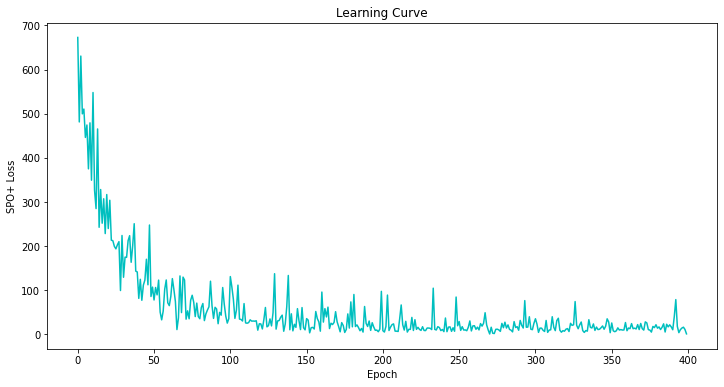

In [23]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

## Evaluation 

In [24]:
import numpy as np
from evalm import SPOEval

In [25]:
# evaluate
spoloss = SPOEval(lr, sp_model, sp_loader_test)
print('Normalized SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized SPO Loss: 0.43%


In [26]:
# compare solutions
lr.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = lr(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy().tolist()
    w = w.to('cpu').detach().numpy().tolist()
    z = z.to('cpu').detach().numpy().tolist()
    cp = cp.to('cpu').detach().numpy().tolist()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j][0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 318.63, 132.21, 82.00, 327.91, 127.54, 257.18, 116.55, 83.78, 401.33, 151.26, 257.18, 150.98, 228.57, 83.78, 365.31, 83.78, 156.28, 60.65, 28.70, 257.18, 150.98, 60.65, 97.35, 224.77, 192.93, 116.55, 365.31, 365.31, 41.02, 169.97, 34.79, 228.57, 34.79, 132.21, 82.00, 169.97, 116.55, 169.97, 51.24, 60.65
    Pred cost: 105.73, -1.34, 50.22, 31.74, -104.11, 114.54, -51.79, 44.73, 30.69, 28.30, 22.68, 22.16, 98.61, -146.00, 122.79, -50.04, -7.31, 87.69, -141.97, 44.77, -0.84, 61.48, -21.92, -55.52, 8.38, -32.43, 106.27, -16.27, -53.89, -12.63, -30.23, -15.68, -15.68, -28.78, -19.48, 52.30, -15.37, -21.69, -40.37, -52.23
    True sol: 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, True obj: 749.90
    Pred sol: 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, Pred obj: 749.90

Sample 1:
    True cost: 3.59, 47.00, 82.00, 15

##  Training with Regularization

In [27]:
# init model
lr = LinearRegression()
# cuda
if torch.cuda.is_available():
    lr = lr.cuda()

In [28]:
# set optimizer
optimizer = torch.optim.Adam(lr.parameters(), lr=5e-2)

In [29]:
# train model
num_epochs = 400
lr.train()
loss_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = lr(x)
        loss = criterion.apply(sp_model, cp, c, w, z).mean()
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print('epoch {}, loss:{:.6f}'.format(epoch+1, loss.item()))

epoch 10, loss:516.980042
epoch 20, loss:191.357590
epoch 30, loss:162.569855
epoch 40, loss:98.365944
epoch 50, loss:104.788200
epoch 60, loss:54.734283
epoch 70, loss:150.373825
epoch 80, loss:54.878471
epoch 90, loss:39.655060
epoch 100, loss:42.032284
epoch 110, loss:65.423470
epoch 120, loss:30.712301
epoch 130, loss:30.578964
epoch 140, loss:68.301712
epoch 150, loss:45.626488
epoch 160, loss:21.594521
epoch 170, loss:28.645906
epoch 180, loss:17.963242
epoch 190, loss:57.131176
epoch 200, loss:35.939404
epoch 210, loss:23.192759
epoch 220, loss:36.715794
epoch 230, loss:45.498371
epoch 240, loss:25.689430
epoch 250, loss:26.010920
epoch 260, loss:11.456385
epoch 270, loss:18.821064
epoch 280, loss:20.342735
epoch 290, loss:11.755850
epoch 300, loss:18.657734
epoch 310, loss:24.711864
epoch 320, loss:10.161060
epoch 330, loss:18.549446
epoch 340, loss:10.060714
epoch 350, loss:28.696041
epoch 360, loss:11.483892
epoch 370, loss:25.503872
epoch 380, loss:15.154787
epoch 390, loss:

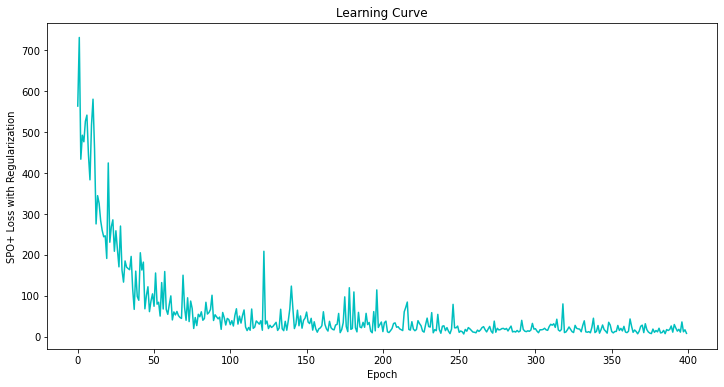

In [30]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss with Regularization')
plt.title('Learning Curve')
plt.show()

## Evaluation 

In [31]:
# evaluate
spoloss = SPOEval(lr, sp_model, sp_loader_test)
print('Normalized SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized SPO Loss: 0.26%


In [32]:
# compare solutions
lr.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = lr(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy().tolist()
    w = w.to('cpu').detach().numpy().tolist()
    z = z.to('cpu').detach().numpy().tolist()
    cp = cp.to('cpu').detach().numpy().tolist()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j][0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 318.63, 132.21, 82.00, 327.91, 127.54, 257.18, 116.55, 83.78, 401.33, 151.26, 257.18, 150.98, 228.57, 83.78, 365.31, 83.78, 156.28, 60.65, 28.70, 257.18, 150.98, 60.65, 97.35, 224.77, 192.93, 116.55, 365.31, 365.31, 41.02, 169.97, 34.79, 228.57, 34.79, 132.21, 82.00, 169.97, 116.55, 169.97, 51.24, 60.65
    Pred cost: 111.53, 1.90, 54.57, 49.67, -93.71, 127.42, -49.37, 97.07, 51.67, 29.72, 21.14, 20.49, 100.65, -132.23, 132.89, -49.91, -10.22, 88.01, -132.97, 58.52, 6.55, 44.56, -15.11, -39.05, 14.54, -26.38, 107.49, 0.92, -51.45, -2.84, -24.74, -7.95, -11.69, -26.83, -8.20, 49.72, -10.14, -19.43, -42.83, -42.78
    True sol: 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, True obj: 749.90
    Pred sol: 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, Pred obj: 749.90

Sample 1:
    True cost: 3.59, 47.00, 82.00, 15.73, 